In [1]:
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra

import pingouin as pg
from fooof import FOOOFGroup
from natsort import natsorted


from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt

import seaborn as sns
import contextlib
import arviz as az
import pymc as pm
import aesara.tensor as at

from fooof.utils import interpolate_spectrum

import bambi as bmb
import sys
sys.path.append('/mnt/obob/staff/fschmidt/cardiac_1_f/')
from utils.fooof_utils import check_outliers, get_good_idx
from utils.plot_utils import plot_ridge
from utils.pymc_utils import coefficients2pcorrs
from scipy.stats import zscore


#%matplotlib inline
sns.set_style('ticks')
sns.set_context('poster')

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def interpolate_powerline(freqs, psd, line_freqs):

    for line_freq in line_freqs:

        _, psd = interpolate_spectrum(freqs, psd, line_freq)
    
    return psd

In [3]:
DATA_DIR = '../data/data_ecg_only/'
FS = 1000
subject_info = pd.read_csv(join(DATA_DIR, 'subject-info.csv'))

all_files = natsorted(listdir(DATA_DIR))

all_data = np.array([file[:-4] for file in all_files if '.dat' in file])

In [5]:
#%%capture
psd_data, irasa_data = [], []

for idx, data in enumerate(all_data):

    print(f'Current file is: {idx}')

    data_record = wfdb.rdsamp(join(DATA_DIR, data))

    cur_data = data_record[0][:,0]
    times = create_times(len(data_record[0])/FS, FS)
    
    cur_data = cur_data[times < subject_info['Length'].min()*60]
    
    #Compute standard hrv data
    nperseg = FS*2

    freqs, psd = compute_spectrum(cur_data, FS, method='welch', avg_type='median', nperseg=nperseg, noverlap=nperseg/2) #

    line_freqs = [[48, 52], [98, 102], [148, 152], [198, 202], [248, 252], [298, 302], [348, 352],]

    psd_interpol = interpolate_powerline(freqs, psd, line_freqs)

    psd_data.append(psd_interpol)

Current file is: 0
Current file is: 1
Current file is: 2


Current file is: 3
Current file is: 4
Current file is: 5
Current file is: 6
Current file is: 7
Current file is: 8
Current file is: 9
Current file is: 10
Current file is: 11
Current file is: 12
Current file is: 13
Current file is: 14
Current file is: 15
Current file is: 16
Current file is: 17
Current file is: 18
Current file is: 19
Current file is: 20
Current file is: 21
Current file is: 22
Current file is: 23
Current file is: 24
Current file is: 25
Current file is: 26
Current file is: 27
Current file is: 28
Current file is: 29
Current file is: 30
Current file is: 31
Current file is: 32
Current file is: 33
Current file is: 34
Current file is: 35
Current file is: 36
Current file is: 37
Current file is: 38
Current file is: 39
Current file is: 40
Current file is: 41
Current file is: 42
Current file is: 43
Current file is: 44
Current file is: 45
Current file is: 46
Current file is: 47
Current file is: 48
Current file is: 49
Current file is: 50
Current file is: 51
Current file is: 52
Current

In [6]:
df_psd = pd.DataFrame(np.transpose(psd_data))
df_psd['Frequency (Hz)'] = freqs
df_psd_tidy = df_psd.melt(id_vars='Frequency (Hz)')


psd2fooof = np.array(psd_data)
good_files = [~(np.isnan(file).sum() > 0) for file in psd2fooof] #only take spectra without nans
psd2fooof = psd2fooof[good_files]

#Get good idcs in subject info
good_idcs = [int(file) for file in np.array(all_data)[good_files]]
subject_info_clean = subject_info.loc[subject_info['ID'].isin(good_idcs)]

In [7]:
psd_d0 = np.array(psd_data)[good_files][subject_info_clean['Device'] == 0].mean(axis=0)
psd_d1 = np.array(psd_data)[good_files][subject_info_clean['Device'] == 1].mean(axis=0)

In [8]:
def read_process_meg_ecg_psd(path, knee, exp_range=None):

    df_meg_psd = pd.read_csv(path)
    df_meg_psd_cut = df_meg_psd.query('channel == 0')
    df_meg_psd_cut = df_meg_psd_cut[['Frequency (Hz)', 'ECG Electrode', 'age', 'subject_id']]
    avg_psd2plot = df_meg_psd_cut.groupby('Frequency (Hz)').mean().reset_index()

    wide_meg_psd = df_meg_psd_cut.pivot(values='ECG Electrode', index='subject_id', columns='Frequency (Hz)')

    freqs_meg = wide_meg_psd.columns.to_numpy()
    psd2fooof_meg = wide_meg_psd.to_numpy()
    df_meg_age = df_meg_psd_cut.drop_duplicates(subset='subject_id')[['age', 'subject_id']].reset_index()


    line_freqs = [[48, 52], [98, 102],]
    psd2fooof_interpol = np.array([interpolate_powerline(freqs_meg, psd, line_freqs) for psd in psd2fooof_meg])

    if exp_range == None:
        exp_range = [45, 95, 145, 195]

    corr_meg, df_all_cmb_meg = [],[]

    for freq in exp_range:
        #Pretty obvious knee in the data 

        if knee:
            fg = FOOOFGroup(max_n_peaks=2, aperiodic_mode='knee', peak_width_limits=[1, 6])
        else:
            fg = FOOOFGroup(max_n_peaks=2, peak_width_limits=[1, 6])

        fg.fit(freqs_meg, psd2fooof_interpol, freq_range=(0.1, freq), progress='tqdm')

        aps = pd.DataFrame(fg.get_params('aperiodic_params'))

        if knee:
            aps.columns = ['Offset', 'Knee', 'Exponent']
        else:
            aps.columns = ['Offset', 'Exponent']


        s_info_clean = df_meg_age.loc[get_good_idx(fg, thresh=2.5)].reset_index()
        aps_clean = aps.loc[get_good_idx(fg, thresh=2.5)].reset_index()

        
        df_cmb_meg = pd.concat([aps_clean, s_info_clean], axis=1)
        df_cmb_meg['fm_freq'] = freq
        df_all_cmb_meg.append(df_cmb_meg)

        corr_meg.append(pg.corr(df_cmb_meg['Exponent']*-1, df_cmb_meg['age'])['r'])

    return corr_meg, df_all_cmb_meg, psd2fooof_meg, freqs_meg

#corr_meg_sbg, df_all_cmb_meg_sbg, psd2plot_sbg, freqs_meg_sbg = read_process_meg_ecg_psd('../data/sbg_1_f_dataframe_1_145_psd.csv', knee=False)
#corr_meg_cc, df_all_cmb_meg_cc, psd2plot_cc,  freqs_meg_cc = read_process_meg_ecg_psd('../data/cam_can_1_f_dataframe_1_145_psd.csv', knee=False)

corr_meg_sbg_k, df_all_cmb_meg_sbg_k, psd2plot_sbg_k, freqs_meg_sbg = read_process_meg_ecg_psd('../data/sbg_1_f_dataframe_1_145_psd.csv', knee=True)
corr_meg_cc_k, df_all_cmb_meg_cc_k, psd2plot_cc_k, freqs_meg_cc = read_process_meg_ecg_psd('../data/cam_can_1_f_dataframe_1_145_psd.csv', knee=True)

Running FOOOFGroup:  60%|██████    | 396/655 [00:08<00:06, 42.02it/s]/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
Running FOOOFGroup:  21%|██        | 138/655 [00:04<00:22, 23.03it/s]/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
Running FOOOFGroup:  21%|██        | 137/655 [00:04<00:17, 29.03it/s]/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
Running FOOOFGroup: 100%|██████████| 626/626 [00:19<00:00, 32.30it/s]


In [9]:
def spectra2pandas(psd2plot, device):

    data2pandas = pd.DataFrame(psd2plot.T)
    data2pandas['Frequency (Hz)'] = freqs_meg_cc
    tidy = data2pandas.melt(id_vars='Frequency (Hz)')
    tidy.columns = ['Frequency (Hz)', 'subject', 'Power (V$^2$/Hz)']
    tidy['Device'] = device

    return tidy
    

d2_3plot = spectra2pandas(psd2plot_cc_k, 3)
d2_4plot = spectra2pandas(psd2plot_sbg_k, 4)


def physionetspectra2pandas(device):

    data2pandas = pd.DataFrame(psd2fooof[subject_info_clean['Device'] == device].T)
    data2pandas['Frequency (Hz)'] = freqs
    tidy = data2pandas.melt(id_vars='Frequency (Hz)')
    tidy.columns = ['Frequency (Hz)', 'subject', 'Power (V$^2$/Hz)']
    tidy['Device'] = device

    return tidy

d2_1plot = physionetspectra2pandas(0)
d2_2plot = physionetspectra2pandas(1)

physio_cmb = pd.concat([d2_1plot, d2_2plot, d2_3plot, d2_4plot])

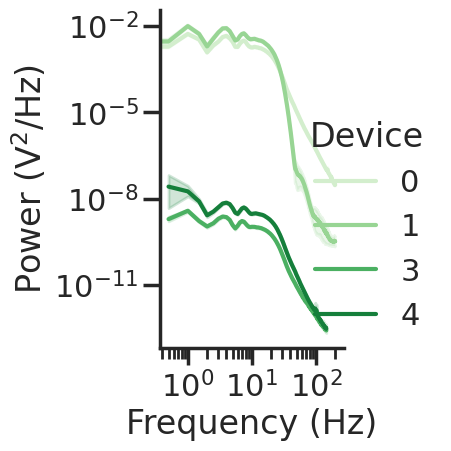

In [10]:
sns.set_style('ticks')
sns.set_context('poster')

pal = ['#D3EECD', '#98D594', '#4BB062', '#157F3B']

g = sns.relplot(data=physio_cmb[physio_cmb['Frequency (Hz)'] < 200],  x='Frequency (Hz)', y='Power (V$^2$/Hz)', hue='Device', kind='line', palette=pal)
g.axes[0,0].set_yscale('log')
g.axes[0,0].set_xscale('log')

g.figure.set_size_inches(5, 5)
g.figure.savefig('../results/ga_ecg_psd.svg')

In [11]:
g.figure.savefig('../results/ga_ecg_psd_10_4.svg')

In [11]:
#exps_cmb_150_meg_cc = pd.concat(df_all_cmb_meg_cc).query('fm_freq == 145')
#exps_cmb_150_meg_sbg = pd.concat(df_all_cmb_meg_sbg).query('fm_freq == 145')

exps_cmb_150_meg_cc_k = pd.concat(df_all_cmb_meg_cc_k).query('fm_freq == 145')
exps_cmb_150_meg_sbg_k = pd.concat(df_all_cmb_meg_sbg_k).query('fm_freq == 145')

In [72]:
pd.concat(df_all_cmb_meg_cc_k)

,index,Offset,Knee,Exponent,level_0,index,age,subject_id,fm_freq
0,0,3.757665,7.464077e+12,8.862271,0,0,24.17,CC110033,45
1,1,1.297442,7.456619e+09,7.638052,1,29580,18.75,CC110037,45
2,2,-7.536953,3.042442e+00,1.263016,2,59160,24.50,CC110045,45
3,3,-1.529155,2.795546e+07,5.646427,3,88740,22.67,CC110056,45
4,4,2.067506,1.368811e+11,8.126251,4,118320,28.67,CC110069,45
...,...,...,...,...,...,...,...,...,...
601,621,-6.376298,7.593051e+02,3.112072,621,18369180,79.33,CC722542,195
602,622,-2.085488,5.793131e+06,5.064134,622,18398760,79.83,CC722651,195
603,623,-3.540123,4.457487e+05,4.285845,623,18428340,84.42,CC722891,195
604,624,-2.336076,2.057529e+06,5.084308,624,18457920,80.08,CC723197,195


In [71]:
exps_cmb_150_meg_cc_k

,index,Offset,Knee,Exponent,level_0,index,age,subject_id,fm_freq,Device,Age_group
0,0,-3.247607,True,4.526338,0,0,24.17,CC110033,145,2,3
1,1,-4.528385,True,3.904951,1,29580,18.75,CC110037,145,2,1
2,2,-6.520816,True,1.907441,2,59160,24.50,CC110045,145,2,3
3,3,-2.742845,True,4.933702,3,88740,22.67,CC110056,145,2,2
4,4,-1.350245,True,5.857041,4,118320,28.67,CC110069,145,2,3
...,...,...,...,...,...,...,...,...,...,...,...
601,621,-6.376298,True,3.112072,621,18369180,79.33,CC722542,145,2,14
602,622,-2.085488,True,5.064134,622,18398760,79.83,CC722651,145,2,14
603,623,-3.540123,True,4.285845,623,18428340,84.42,CC722891,145,2,15
604,624,-2.336076,True,5.084308,624,18457920,80.08,CC723197,145,2,14


In [12]:
def fit_fooof_range(knee):

    d_0_corr, d_1_corr, exps_list, df_all_cmb = [],[],[],[]

    exp_range = [2, 45, 95, 145, 195, 245, 295, 345, 395]

    #if knee:
    exp_range = exp_range[1:]

    for freq in exp_range:
        #Pretty obvious knee in the data
        #Yet fitting with a knee doesnt seem to change the age correlation -> rather improves it
        #fitting without a knee for now for comparability with the results from meg
        if knee:
            fg = FOOOFGroup(max_n_peaks=2, aperiodic_mode='knee', peak_width_limits=[1, 6])
        else:
            fg = FOOOFGroup(max_n_peaks=2, peak_width_limits=[1, 6])

        fg.fit(freqs, psd2fooof, freq_range=(0.1, freq), progress='tqdm')

        aps = pd.DataFrame(fg.get_params('aperiodic_params'))

        if knee:
            aps.columns = ['Offset', 'Knee', 'Exponent'] #
        else:
            aps.columns = ['Offset', 'Exponent']
        exps_list.append(aps['Exponent'])

        s_info_clean = subject_info_clean.loc[get_good_idx(fg, thresh=2.5)].reset_index()
        aps_clean = aps.loc[get_good_idx(fg, thresh=2.5)].reset_index()

        df_cmb = pd.concat([aps_clean, s_info_clean], axis=1)
        df_cmb['fm_freq'] = freq
        df_all_cmb.append(df_cmb)

        d_0 = df_cmb.query('Device == 0')
        d_1 = df_cmb.query('Device == 1')
        
        d_0_corr.append(pg.corr(d_0['Exponent']*-1, d_0['Age_group'])['r'])
        d_1_corr.append(pg.corr(d_1['Exponent']*-1, d_1['Age_group'])['r'])

    return  d_0_corr, d_1_corr, exps_list, df_all_cmb



In [13]:
#d_0_corr, d_1_corr, exps_list, df_all_cmb = fit_fooof_range(knee=False)
d_0_corr_k, d_1_corr_k, exps_list_k, df_all_cmb_k = fit_fooof_range(knee=True)

Running FOOOFGroup:   4%|▍         | 42/1105 [00:02<00:54, 19.64it/s]/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
Running FOOOFGroup:  18%|█▊        | 201/1105 [00:09<00:39, 22.64it/s]/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
Running FOOOFGroup:  48%|████▊     | 530/1105 [00:25<00:27, 20.68it/s]/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
Running FOOOFGroup:   4%|▍         | 42/1105 [00:02<00:56, 18.91it/s]/mnt/obob/staff/fschmidt/conda_cache/envs/ml/lib/python3.9/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered i

In [14]:
from fooof.utils.params import compute_knee_frequency

df_cmb_pn = pd.concat(df_all_cmb_k).query('fm_freq == 145')
d0 = df_cmb_pn.query('Device == 0')
d1 = df_cmb_pn.query('Device == 1')

knee_d0 = compute_knee_frequency(d0['Knee'], d0['Exponent'])
knee_d1 = compute_knee_frequency(d1['Knee'], d1['Exponent'])
knee_d2 = compute_knee_frequency(exps_cmb_150_meg_cc_k['Knee'], exps_cmb_150_meg_cc_k['Exponent'])
knee_d3 = compute_knee_frequency(exps_cmb_150_meg_sbg_k['Knee'], exps_cmb_150_meg_sbg_k['Exponent'])

In [15]:
print(knee_d0.mean(), knee_d0.std())
print(knee_d1.mean(), knee_d1.std())
print(knee_d2.mean(), knee_d2.std())
print(knee_d3.mean(), knee_d3.std())

15.66822066796557 5.698142725685038
10.297694342352793 2.782133161045741
14.102456539015758 6.456212754085843
16.043731384595233 6.438109288339425


In [16]:
knee_list = [knee_d0, knee_d1, knee_d2, knee_d3]

print(np.nanmean(np.concatenate(knee_list)), np.nanstd(np.concatenate(knee_list)))

14.226551360898972 6.0642395386023145


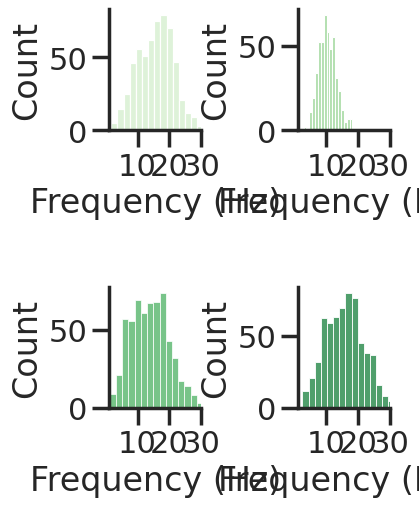

In [17]:

fig, axes = plt.subplots(2,2)
axes = axes.reshape(-1)
colors = ['#D3EECD', '#98D594', '#4BB062', '#157F3B']

for ax, cur_knee, color in zip(axes, knee_list, colors):
    sns.histplot(cur_knee, ax=ax, color=color)
    ax.set_xlim(1, 30)
    ax.set_xlabel('Frequency (Hz)')

fig.tight_layout()
fig.set_size_inches(4,6)
sns.despine()
fig.savefig('../results/knee_freq_hist.svg')

In [20]:
exps_knee = pd.concat(df_all_cmb_k)[['fm_freq', 'Exponent', 'ID', 'Device']]


NameError: name 'exps_no_knee' is not defined

/tmp/ipykernel_17559/3869187347.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(freqs, rotation = 90)


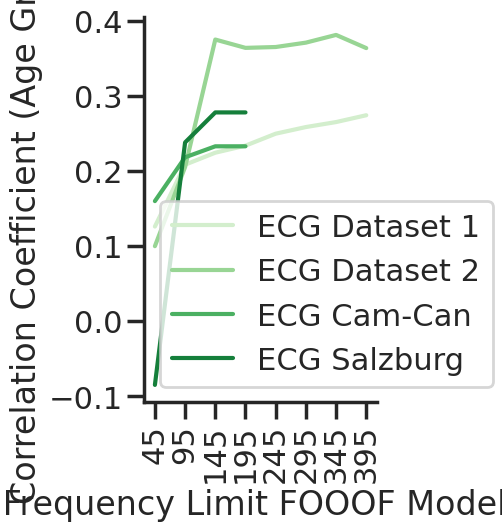

In [21]:
freqs = ['45', '95', '145', '195', '245', '295', '345', '395']
fig, ax = plt.subplots()
exp_range = ['45', '95', '145', '195',]
 
ax.plot(freqs, np.array(d_0_corr_k).flatten(), label='ECG Dataset 1', color='#D3EECD')
ax.plot(freqs, np.array(d_1_corr_k).flatten(), label='ECG Dataset 2', color='#98D594')
ax.plot(exp_range, np.array(corr_meg_cc_k).flatten(), label='ECG Cam-Can', color='#4BB062')
ax.plot(exp_range, np.array(corr_meg_sbg_k).flatten(), label='ECG Salzburg', color='#157F3B')
ax.set_ylabel('Correlation Coefficient (Age Group)')
ax.set_xlabel('Upper Frequency Limit FOOOF Model fit (Hz)')
ax.legend()
ax.set_xticklabels(freqs, rotation = 90)
fig.set_size_inches(3, 5)
sns.despine()
fig.savefig('../results/corr_age_freq_range_ecg_only_hf_knee_4.svg')

In [22]:
#df_cmb_150 = pd.concat(df_all_cmb).query('fm_freq == 145')
df_cmb_150_k = pd.concat(df_all_cmb_k).query('fm_freq == 145')
#df_cmb_150.dropna(inplace=True) #need to drop this now to save trouble in my bayesian models
df_cmb_150_k.dropna(inplace=True)


def add_age_groups(ecg_meg):

        #recode in age group to plot ecg from meg and ecg from other devices on the same scale

        #1 (18-19 years), 2 (20-24 years), 3 (25-29 years), 4 (30-34 years), 5 (35-39 years), 
        #6 (40-44 years), 7 (45-49 years), 8 (50-54 years), 9 (55-59 years), 10 (60-64 years), 
        #11 (65-69 years), 12 (70-74 years), 13 (75-79 years), 14 (80-84 years), 15 (85-92 years)
        #note this probably wont change the age corr a lot as a check precompute here


        #i hate recoding.. but necessary for figure

        #ag_list = [18, 19, 20, 24, 25, 29, 30, 34, 35, 39, 40, 44, 45, 49, 50, 54, 55, 59, 60, 64,
        # 65, 69, 70, 74, 75, 79, 80, 84, 85, 92]

        ag_list = [17, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 92]

        labels = np.arange(1, 16)
        ecg_meg['Age_group'] = pd.cut(ecg_meg['age'], bins=ag_list, labels=labels)

        return ecg_meg

#read meg data
def ecg_from_meg(path, device_n):

        ecg_meg = pd.read_csv(path).query('channel == 0')[['heart_slope', 'age', 'subject_id']]
        ecg_meg.reset_index(inplace=True)

        ecg_meg.drop(columns='index', inplace=True)
        ecg_meg.columns = ['Exponent', 'age', 'subject_id']
        ecg_meg['Device'] = device_n

        ecg_meg = add_age_groups(ecg_meg)

        return ecg_meg



exp_ecg_cam_can = ecg_from_meg('../data/cam_can_1_f_dataframe_1_145.csv', 3)
exp_ecg_sbg = ecg_from_meg('../data/sbg_1_f_dataframe_1_145.csv', 4)
#ecg_meg.drop(columns='age', inplace=True)

In [75]:



def add_infos2ecg(df, device_n):

    meg_cc = pd.concat(df)
    meg_cc = add_age_groups(meg_cc)
    meg_cc['Device'] = device_n
    
    return meg_cc[['Exponent', 'Age_group', 'fm_freq', 'Device']]


add_infos2ecg(df_all_cmb_meg_cc_k, 3)
add_infos2ecg(df_all_cmb_meg_sbg_k, 4)

,Exponent,Age_group,fm_freq,Device
0,6.818220,2,45,4
1,4.447921,12,45,4
2,6.828747,12,45,4
3,6.590377,12,45,4
4,6.697359,12,45,4
...,...,...,...,...
630,6.113653,1,195,4
631,3.728580,1,195,4
632,6.526916,1,195,4
633,4.647951,1,195,4


In [80]:
df2test_across_tmp = pd.concat(df_all_cmb_k)[['Exponent', 'Age_group', 'fm_freq', 'Device']]

df2test_across = pd.concat([df2test_across_tmp, add_infos2ecg(df_all_cmb_meg_cc_k, 3), add_infos2ecg(df_all_cmb_meg_sbg_k, 4)])
df2test_across['Slope'] = df2test_across['Exponent'] * -1

In [83]:

all_beta_dfs = []

sample_kwargs = {'draws': 2000,
               'tune': 2000,
               'chains': 4,
               'target_accept': 0.9,}

for device in df2test_across['Device'].unique():

    cur_device = df2test_across.query(f'Device == {device}')

    for freq in cur_device['fm_freq'].unique():

        cur_ds = cur_device.query(f'fm_freq == {freq}')[['Slope', 'Age_group']].copy().dropna()

        mdf = bmb.Model(formula = 'Slope ~ Age_group', data=zscore(cur_ds), family='t').fit(**sample_kwargs)
        summ = az.summary(mdf).loc['Age_group']

        df_tmp = pd.DataFrame(summ).T[['mean', 'sd', 'hdi_3%', 'hdi_97%']]
        df_tmp['freq'] = freq
        df_tmp['Device'] = device

        all_beta_dfs.append(df_tmp)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, Age_group, Slope_sigma, Slope_nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.


In [86]:
ecg_betas = pd.concat(all_beta_dfs)

ecg_betas.to_csv('../data/ecg_effs_across_devices.csv')

In [94]:
df_beta2plot = ecg_betas[['hdi_3%', 'hdi_97%', 'freq', 'Device']].melt(id_vars=['freq', 'Device'])

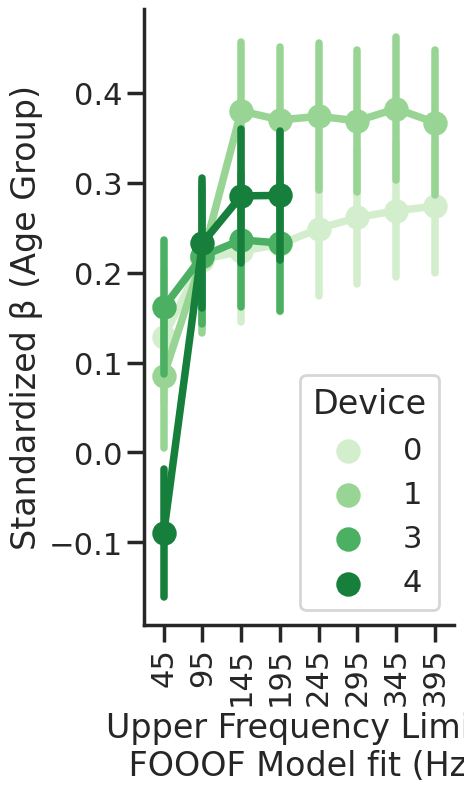

In [106]:
fig, ax = plt.subplots(figsize=(4,8))

sns.pointplot(df_beta2plot, y='value', x='freq', palette=colors,
                 hue='Device',  errorbar=('ci', 100), ax=ax)

ax.set_ylabel('Standardized β (Age Group)')
ax.set_xlabel('Upper Frequency Limit \n FOOOF Model fit (Hz)')
ax.set_xticklabels(df_beta2plot['freq'].unique(), rotation = 90)


sns.despine()
fig.savefig('../results/ecg_effect_across_freqs.svg')

In [23]:
#there are probably better way of doing this, but i am too lazy to think right now
def format4expcorr(data, device_n, Knee):

    data['Device'] = device_n
    data['Knee'] = Knee

    exps = data[['Device', 'Knee', 'Exponent', 'subject_id']]

    return exps

df_cmb_150_k['Knee'] = True
df_cmb_150_k['subject_id'] = np.arange(len(df_cmb_150_k))
#df_cmb_150['Knee'] = False

all4knee_corr = pd.concat([#,
                           df_cmb_150_k[['Device', 'Knee', 'Exponent', 'subject_id']],
                           format4expcorr(exps_cmb_150_meg_cc_k, 2, True),
                           format4expcorr(exps_cmb_150_meg_sbg_k, 3, True),])

#df4corr_knee = all4knee_corr.query('Knee == False')[['Device', 'Exponent', 'subject_id']].merge(all4knee_corr.query('Knee == True')[['Device', 'Exponent', 'subject_id']], on=['subject_id', 'Device'])

In [24]:
#df4meg_plot = pd.concat(df_all_cmb).query('fm_freq == 145')[['Exponent', 'Age_group', 'Device']]
df4meg_plot_k = pd.concat(df_all_cmb_k).query('fm_freq == 145')[['Exponent', 'Age_group', 'Device']]

#exps_cmb_150_meg_cc = add_age_groups(exps_cmb_150_meg_cc)
#exps_cmb_150_meg_sbg = add_age_groups(exps_cmb_150_meg_sbg)
exps_cmb_150_meg_cc_k = add_age_groups(exps_cmb_150_meg_cc_k)
exps_cmb_150_meg_sbg_k = add_age_groups(exps_cmb_150_meg_sbg_k)

#df2corr = pd.concat([df4meg_plot, exps_cmb_150_meg_cc[['Exponent', 'Age_group', 'Device']], exps_cmb_150_meg_sbg[['Exponent', 'Age_group', 'Device']]])

df2corr_k = pd.concat([df4meg_plot_k, exps_cmb_150_meg_cc_k[['Exponent', 'Age_group', 'Device']], exps_cmb_150_meg_sbg_k[['Exponent', 'Age_group', 'Device']]])

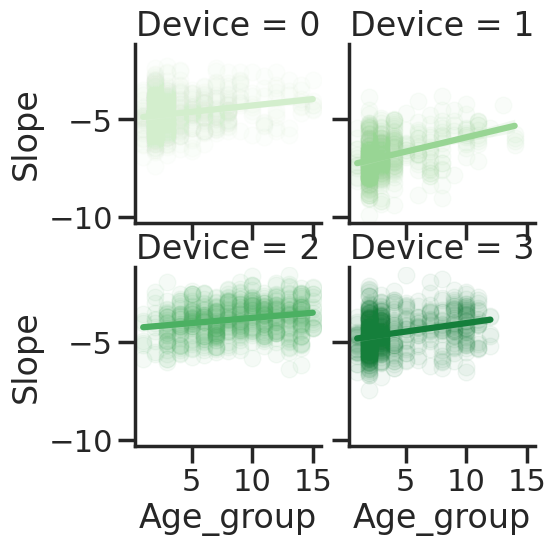

In [25]:
df2corr_k['Slope'] = df2corr_k['Exponent'] * -1
g = sns.lmplot(data=df2corr_k, x='Age_group', y='Slope', hue='Device', palette='Greens', 
                col='Device', col_wrap=2,
                scatter_kws={'alpha': 0.05})

g.figure.set_size_inches(5, 5, forward=True)
g.figure.savefig('../results/ecg_only_age_k.svg')

In [26]:
d_04baycor = df2corr_k.query('Device == 0')[['Exponent', 'Age_group']].copy().dropna()
d_14baycor = df2corr_k.query('Device == 1')[['Exponent', 'Age_group']].copy().dropna()
d_24baycor = df2corr_k.query('Device == 2')[['Exponent', 'Age_group']].copy().dropna()
d_34baycor = df2corr_k.query('Device == 3')[['Exponent', 'Age_group']].copy().dropna()

In [39]:
mdf = bmb.Model(formula = 'Exponent ~ Age_group', data=zscore(d_34baycor), family='t').fit()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Intercept, Age_group, Exponent_sigma, Exponent_nu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [47]:
sum = az.summary(mdf).loc['Age_group']
sum

mean           -0.284
sd              0.038
hdi_3%         -0.351
hdi_97%        -0.210
mcse_mean       0.001
mcse_sd         0.001
ess_bulk     2505.000
ess_tail     1269.000
r_hat           1.000
Name: Age_group, dtype: float64

In [110]:
#Calculate bayesian correlation
def baycor(data):
    with pm.Model() as correlation_model:

        # set some more or less informative priors here
        mu_exp = pm.Normal('mu_exp', mu=0, sigma=10.) #
        mu_age = pm.Normal('mu_age', mu=0, sigma=10.) # age is coded in groups here: think about whether a normal really makes sense here

        #prior on correlation
        chol, corr, stds = pm.LKJCholeskyCov("chol", n=2, eta=4.0, 
                   sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True)

        #stack data together
        mu = at.stack((mu_exp, mu_age), axis=1)
    
        #observed data
        y = pm.MvNormal('y', mu=mu, chol=chol, observed=data)

        trace = pm.sample(**brms_kwargs)
    return trace


trace_d0 = baycor(d_04baycor)    
trace_d1 = baycor(d_14baycor)    
trace_d2 = baycor(d_24baycor) 
trace_d3 = baycor(d_34baycor) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp, mu_age, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 112 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp, mu_age, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 113 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp, mu_age, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 113 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp, mu_age, chol]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 113 seconds.


In [111]:
az.summary(trace_d0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_exp,4.661,0.041,4.584,4.739,0.000,0.000,8395.0,5940.0,1.0
mu_age,4.269,0.135,4.022,4.528,0.001,0.001,8144.0,6889.0,1.0
chol[0],0.975,0.029,0.921,1.031,0.000,0.000,7689.0,6400.0,1.0
chol[1],-0.710,0.132,-0.945,-0.455,0.001,0.001,8551.0,5823.0,1.0
chol[2],3.097,0.094,2.925,3.278,0.001,0.001,8770.0,6430.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[0, 1]",-0.223,0.040,-0.294,-0.146,0.000,0.000,8711.0,6195.0,1.0
"chol_corr[1, 0]",-0.223,0.040,-0.294,-0.146,0.000,0.000,8711.0,6195.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,7346.0,7407.0,1.0
chol_stds[0],0.975,0.029,0.921,1.031,0.000,0.000,7689.0,6400.0,1.0


In [112]:
az.summary(trace_d1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_exp,6.579,0.049,6.486,6.668,0.001,0.000,7018.0,6120.0,1.0
mu_age,3.753,0.119,3.526,3.976,0.001,0.001,7298.0,6163.0,1.0
chol[0],1.081,0.034,1.018,1.145,0.000,0.000,7686.0,6231.0,1.0
chol[1],-1.019,0.113,-1.243,-0.819,0.001,0.001,7900.0,6541.0,1.0
chol[2],2.429,0.077,2.283,2.574,0.001,0.001,7990.0,6172.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[0, 1]",-0.386,0.038,-0.455,-0.315,0.000,0.000,7955.0,6325.0,1.0
"chol_corr[1, 0]",-0.386,0.038,-0.455,-0.315,0.000,0.000,7955.0,6325.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,7545.0,7707.0,1.0
chol_stds[0],1.081,0.034,1.018,1.145,0.000,0.000,7686.0,6231.0,1.0


In [113]:
az.summary(trace_d2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_exp,3.790,0.036,3.719,3.856,0.000,0.000,8320.0,6098.0,1.0
mu_age,8.629,0.149,8.345,8.903,0.002,0.001,8503.0,6485.0,1.0
chol[0],0.893,0.026,0.842,0.942,0.000,0.000,7859.0,6153.0,1.0
chol[1],-0.830,0.146,-1.110,-0.562,0.002,0.001,7766.0,6109.0,1.0
chol[2],3.594,0.103,3.394,3.779,0.001,0.001,9091.0,6126.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[0, 1]",-0.225,0.038,-0.293,-0.150,0.000,0.000,7814.0,6150.0,1.0
"chol_corr[1, 0]",-0.225,0.038,-0.293,-0.150,0.000,0.000,7814.0,6150.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,7216.0,7478.0,1.0
chol_stds[0],0.893,0.026,0.842,0.942,0.000,0.000,7859.0,6153.0,1.0


In [114]:
az.summary(trace_d3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_exp,4.525,0.040,4.448,4.600,0.000,0.000,7886.0,5942.0,1.0
mu_age,4.232,0.120,4.008,4.457,0.001,0.001,7321.0,5862.0,1.0
chol[0],1.005,0.028,0.955,1.061,0.000,0.000,8566.0,5615.0,1.0
chol[1],-0.799,0.118,-1.012,-0.569,0.001,0.001,8855.0,6383.0,1.0
chol[2],2.900,0.080,2.756,3.056,0.001,0.001,8254.0,6256.0,1.0
"chol_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"chol_corr[0, 1]",-0.265,0.037,-0.336,-0.197,0.000,0.000,8937.0,6359.0,1.0
"chol_corr[1, 0]",-0.265,0.037,-0.336,-0.197,0.000,0.000,8937.0,6359.0,1.0
"chol_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,7928.0,8000.0,1.0
chol_stds[0],1.005,0.028,0.955,1.061,0.000,0.000,8566.0,5615.0,1.0
